In [1]:
import numpy as np
import pandas as pd
import warnings
import matplotlib.pyplot as plt
idx = pd.IndexSlice
pd.set_option("display.max_rows",101)
pd.set_option('expand_frame_repr', False)
warnings.simplefilter(action='ignore', category=pd.errors.PerformanceWarning)

# MRChem benchmark calculations

This notebook presents benchmark timings for the MRChem program on a set of molecular calculations using a variable number of CPU cores. The test systems are standard linear alkane chains $C_nH_{2n+2}$, with $n$ ranging from 2 to 350, as well as the Caffeine ($C_{8}H_{10}N_{4}O_{2}$) and Valinomycine ($C_{54}H_{90}N_{6}O_{18}$) molecules. The main purpose of this data is to monitor the development of the code performance between different version, but it will also provide a reference for users to check if the code has been properly installed and runs reasonably on their system. Not all molecular systems will be available in the data, which mirrors the current limitations of the code when it comes to system size and numerical precision. Only a small selection of the data will be presented below, but further details are available by digging into the raw data.

## MRChem SCF cycle

The Self-Consistent Field (SCF) cycle in MRChem contains the following steps:

- Building Fock operator
- Calculating Fock matrix
- Rotating orbitals (diagonalization or localization)
- Calculating SCF energy
- Applying Helmholtz operator
- Applying iterative subspace acceleration (KAIN)

and each of these may have sub steps that can be extracted from the data below. The calculations are performed using one of the following methods:

- Hartree (to show the performance of the backbone SCF algorithm + Coulomb interaction)
- Hartree-Fock (to show the performance of the exact exchange operator)
- DFT-PBE (to show the performance of the density functional integrator)

## Parallel performance

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{10}H_{22}$
molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes and OMP threads per process. The molecule has 82 electrons and 41 doubly occupied molecular orbitals.

In [3]:
molecule='alkane_010'
hybrid_series = pd.read_csv("alkane-hartree/scf.csv", index_col=[0,1,2]).loc[molecule,:,:]
hybrid_series

orbs  Localize  SCF energy  Helmholtz   Lowdin      KAIN  Fock operator  Fock matrix  Total SCF
molecule   MPI OMP                                                                                                 
alkane_010 4   16     41   33.8751     4.57565    76.9911  9.23635  2.699530        7.98179     14.20530   156.1170
           8   8      41   24.9718     3.65413    68.1093  7.18317  2.077450       11.87540     10.53610   133.7860
               16     41   21.4885     2.43207    40.3928  5.94290  1.369230        6.74365      8.85429    92.2407
               32     41   27.6646     3.08027    37.0913  6.94582  2.650180        5.58917     10.49140    99.1419
           16  8      41   18.6406     2.16879    32.7552  9.90904  1.301570        9.97154      7.25288    87.0384
               16     41   15.6455     1.76371    20.0841  8.19827  1.310190        5.92196      5.82305    62.4974
               32     41   17.7280     1.90414    18.9501  7.88125  1.865020        5.66966      6.14989    64.8367
           32  8      41   15.3763     1.95858    22.7004  8.15812  1.037170        8.52039      5.82559    69.0652
               16     41   13.5067     1.40388    13.9788  7.23591  1.161250        5.08227      4.85257    51.4977
               32     41   16.2129     1.05636    15.8540  6.73502  0.993232        5.11201      4.74115    55.6581

## OpenMP scaling

The following table presents timings (in sec) on a single compute node for the different parts of a single SCF cycle for the $C_{10}H_{22}$ molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The molecule has 82 electrons and 41 doubly occupied molecular orbitals.

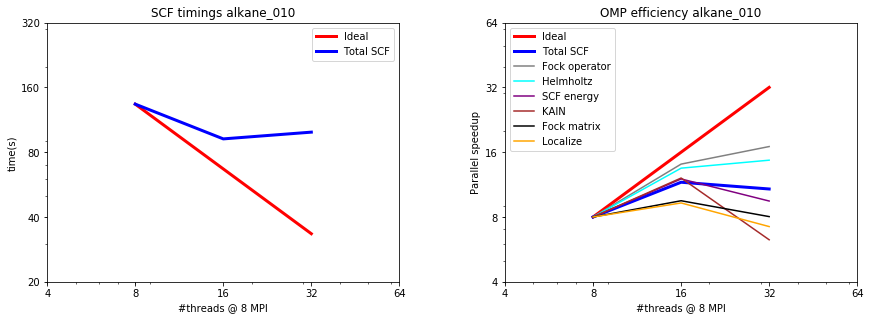

orbs  Localize  SCF energy  Helmholtz   Lowdin     KAIN  Fock operator  Fock matrix  Total SCF
molecule   MPI OMP                                                                                                
alkane_010 8   8      41   24.9718     3.65413    68.1093  7.18317  2.07745       11.87540     10.53610   133.7860
               16     41   21.4885     2.43207    40.3928  5.94290  1.36923        6.74365      8.85429    92.2407
               32     41   27.6646     3.08027    37.0913  6.94582  2.65018        5.58917     10.49140    99.1419

In [13]:
mpi=8
molecule='alkane_010'
omp_frame = pd.read_csv("alkane-hartree/scf.csv", index_col=[0,1,2])
omp_series = omp_frame.loc[molecule,mpi]

plt.subplot(121)
plt.title('SCF timings ' + molecule)
plt.plot(omp_series.index, mpi*omp_series['Total SCF'][mpi]/omp_series.index, 'red', lw=3, label='Ideal')
plt.plot(omp_series['Total SCF'], 'blue', lw=3)
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320], [20, 40, 80, 160, 320])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('time(s)')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplot(122)
plt.title('OMP efficiency ' + molecule)
plt.plot(omp_series.index, omp_series.index, 'red', lw=3, label='Ideal')
plt.plot(mpi*omp_series['Total SCF'][mpi]/omp_series['Total SCF'], 'blue', lw=3)
plt.plot(mpi*omp_series['Fock operator'][mpi]/omp_series['Fock operator'], c='gray')
plt.plot(mpi*omp_series['Helmholtz'][mpi]/omp_series['Helmholtz'], c='cyan')
plt.plot(mpi*omp_series['SCF energy'][mpi]/omp_series['SCF energy'], c='purple')
plt.plot(mpi*omp_series['KAIN'][mpi]/omp_series['KAIN'], c='brown', label='KAIN')
plt.plot(mpi*omp_series['Fock matrix'][mpi]/omp_series['Fock matrix'], c='black')
plt.plot(mpi*omp_series['Localize'][mpi]/omp_series['Localize'], c='orange')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('Parallel speedup')
plt.xlabel('#threads' + ' @ ' + str(mpi) + ' MPI')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
omp_frame.loc[molecule,mpi,:]

## MPI scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{10}H_{22}$
molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes with fixed a single OMP threads per process. The molecule has 82 electrons and 41 doubly occupied molecular orbitals.

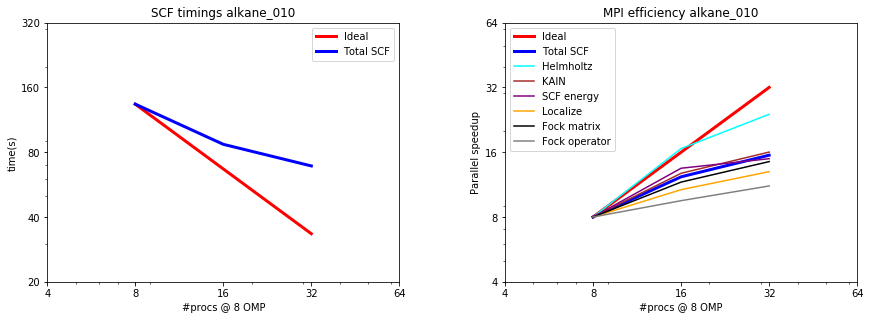

orbs  Localize  SCF energy  Helmholtz   Lowdin     KAIN  Fock operator  Fock matrix  Total SCF
molecule   OMP MPI                                                                                                
alkane_010 8   8      41   24.9718     3.65413    68.1093  7.18317  2.07745       11.87540     10.53610   133.7860
               16     41   18.6406     2.16879    32.7552  9.90904  1.30157        9.97154      7.25288    87.0384
               32     41   15.3763     1.95858    22.7004  8.15812  1.03717        8.52039      5.82559    69.0652

In [12]:
omp=8
ref=8
molecule='alkane_010'
mpi_frame = pd.read_csv("alkane-hartree/scf.csv", index_col=[0,2,1])
mpi_series = mpi_frame.loc[molecule,omp]

plt.subplot(121)
plt.title('SCF timings ' + molecule)
plt.plot(mpi_series.index, ref*mpi_series['Total SCF'][ref]/mpi_series.index, 'red', lw=3, label='Ideal')
plt.plot(mpi_series['Total SCF'], 'blue', lw=3)
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320], [20, 40, 80, 160, 320])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('MPI efficiency ' + molecule)
plt.plot(mpi_series.index, mpi_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*mpi_series['Total SCF'][ref]/mpi_series['Total SCF'], c='blue', lw=3)
plt.plot(ref*mpi_series['Helmholtz'][ref]/mpi_series['Helmholtz'], c='cyan')
plt.plot(ref*mpi_series['KAIN'][ref]/mpi_series['KAIN'], c='brown')
plt.plot(ref*mpi_series['SCF energy'][ref]/mpi_series['SCF energy'], c='purple')
plt.plot(ref*mpi_series['Localize'][ref]/mpi_series['Localize'], c='orange')
plt.plot(ref*mpi_series['Fock matrix'][ref]/mpi_series['Fock matrix'], c='black')
plt.plot(ref*mpi_series['Fock operator'][ref]/mpi_series['Fock operator'], c='gray')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[molecule,omp,:]

## Hybrid MPI/OpenMP scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{6}H_{14}$
molecule at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using an increasing number of MPI processes with fixed 8 OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

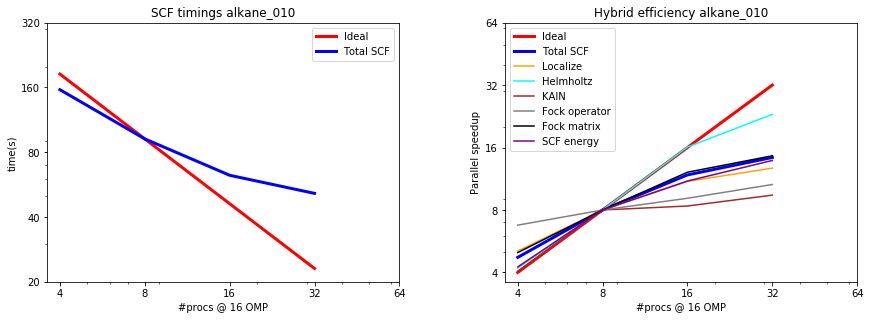

orbs  Localize  SCF energy  Helmholtz   Lowdin     KAIN  Fock operator  Fock matrix  Total SCF
molecule   OMP MPI                                                                                                
alkane_010 16  4      41   33.8751     4.57565    76.9911  9.23635  2.69953        7.98179     14.20530   156.1170
               8      41   21.4885     2.43207    40.3928  5.94290  1.36923        6.74365      8.85429    92.2407
               16     41   15.6455     1.76371    20.0841  8.19827  1.31019        5.92196      5.82305    62.4974
               32     41   13.5067     1.40388    13.9788  7.23591  1.16125        5.08227      4.85257    51.4977

In [11]:
omp=16
ref=8
molecule='alkane_010'
hybrid_frame = pd.read_csv("alkane-hartree/scf.csv", index_col=[0,2,1])
hybrid_series = hybrid_frame.loc[molecule,omp]

plt.subplot(121)
plt.title('SCF timings ' + molecule)
plt.plot(hybrid_series.index, ref*hybrid_series['Total SCF'][ref]/hybrid_series.index, 'red', lw=3, label='Ideal')
plt.plot(hybrid_series['Total SCF'], 'blue', lw=3)
plt.legend(loc='upper right')
plt.yscale('log')
plt.xscale('log')
plt.yticks([20, 40, 80, 160, 320], [20, 40, 80, 160, 320])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('time(s)')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplot(122)
plt.title('Hybrid efficiency ' + molecule)
plt.plot(hybrid_series.index, hybrid_series.index, c='red', lw=3, label='Ideal')
plt.plot(ref*hybrid_series['Total SCF'][ref]/hybrid_series['Total SCF'], c='blue', lw=3)
plt.plot(ref*hybrid_series['Localize'][ref]/hybrid_series['Localize'], c='orange')
plt.plot(ref*hybrid_series['Helmholtz'][ref]/hybrid_series['Helmholtz'], c='cyan')
plt.plot(ref*hybrid_series['KAIN'][ref]/hybrid_series['KAIN'], c='brown')
plt.plot(ref*hybrid_series['Fock operator'][ref]/hybrid_series['Fock operator'], c='gray')
plt.plot(ref*hybrid_series['Fock matrix'][ref]/hybrid_series['Fock matrix'], c='black')
plt.plot(ref*hybrid_series['SCF energy'][ref]/hybrid_series['SCF energy'], c='purple')
plt.legend(loc='upper left')
plt.yscale('log')
plt.xscale('log')
plt.yticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.xticks([4, 8, 16, 32, 64], [4, 8, 16, 32, 64])
plt.ylabel('Parallel speedup')
plt.xlabel('#procs' + ' @ ' + str(omp) + ' OMP')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mpi_frame.loc[molecule,omp,:]

## System scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{n}H_{2n+2}$
linear alkanes at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using a fixed number of MPI processes and OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

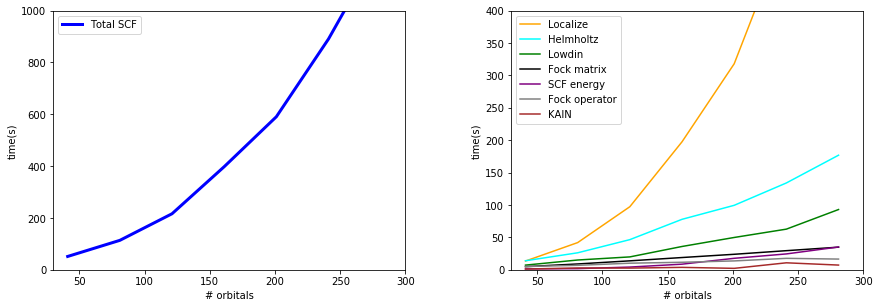

,molecule,Localize,SCF energy,Helmholtz,Lowdin,KAIN,Fock operator,Fock matrix,Total SCF
orbs,,,,,,,,,
41,alkane_010,13.5067,1.40388,13.9788,7.23591,1.16125,5.08227,4.85257,51.4977
81,alkane_020,41.9848,1.78539,26.2377,15.10750,2.83183,6.88956,9.02162,113.6470
121,alkane_030,97.3767,4.22376,46.5529,19.90090,2.62212,10.17860,13.83120,216.2510
161,alkane_040,197.5370,8.68690,77.8971,35.98340,3.75511,11.62460,18.93090,397.8060
201,alkane_050,317.9400,17.73810,99.5097,49.88970,2.23938,13.70290,23.94580,590.5870
241,alkane_060,524.9730,24.49870,134.0200,62.75160,10.78890,17.68290,29.51850,890.7940
281,alkane_070,751.6320,35.20140,176.8490,93.01930,7.28534,16.54930,34.94000,1247.6600


In [9]:
omp=16
mpi=32
mol_frame = pd.read_csv("alkane-hartree/scf.csv", index_col=[1,2,3])
mol_series = mol_frame.loc[mpi,omp]

plt.subplot(121)
plt.plot(mol_series['Total SCF'], 'blue', lw=3)
plt.legend(loc='upper left')
plt.axis([30, 300, 0, 1000])
plt.ylabel('time(s)')
plt.xlabel('# orbitals')

plt.subplot(122)
plt.plot(mol_series['Localize'], 'orange')
plt.plot(mol_series['Helmholtz'], 'cyan')
plt.plot(mol_series['Lowdin'], 'green')
plt.plot(mol_series['Fock matrix'], 'black')
plt.plot(mol_series['SCF energy'], 'purple')
plt.plot(mol_series['Fock operator'], 'gray')
plt.plot(mol_series['KAIN'], 'brown')
plt.legend(loc='upper left')
plt.axis([30, 300, 0, 400])
plt.ylabel('time(s)')
plt.xlabel('# orbitals')

plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()
mol_frame.loc[mpi,omp,:]

## Weak scaling

The following table presents timings (in sec) for the different parts of a single SCF cycle for the $C_{n}H_{2n+2}$
linear alkanes at numerical precision $\epsilon=10^{-5}$, using the Hartree method. The calculations are using a fixed number of MPI processes and OMP threads per process. The molecule has 50 electrons and 25 doubly occupied molecular orbitals.

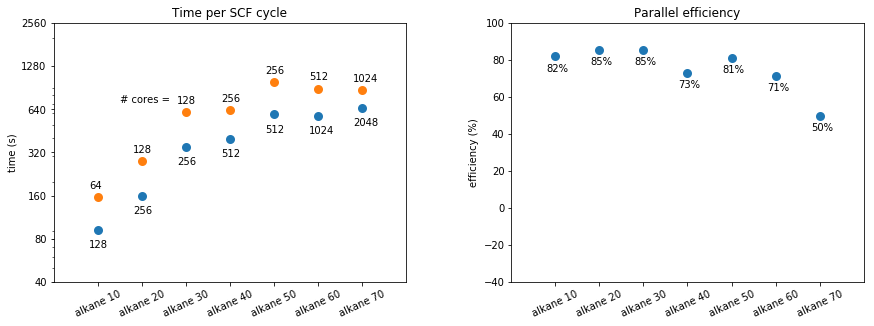

In [14]:
omp = 16
mol_frame = pd.read_csv("alkane-hartree/scf.csv", index_col=[2,1,3])
#print(mol_frame.loc[omp])

orbs  = np.array([  41,  81, 121, 161, 201, 241, 281])
mpi_1 = np.array([   4,   8,   8,  16,  16,  32,  64])
mpi_2 = np.array([   8,  16,  16,  32,  32,  64, 128])
t_1   = np.zeros(7, float)
t_2   = np.zeros(7, float)
for i in range(0, len(orbs)):
    t_1[i] = mol_frame['Total SCF'].loc[omp, mpi_1[i], orbs[i]]
    t_2[i] = mol_frame['Total SCF'].loc[omp, mpi_2[i], orbs[i]]
eff = 100 * (mpi_2/mpi_1) * (t_1 - t_2)/t_1

idx   = np.arange(1, 8)
mol   = ['alkane 10','alkane 20','alkane 30','alkane 40','alkane 50','alkane 60','alkane 70']
time  = np.array([40, 80, 160, 320, 640, 1280, 2560])

plt.subplot(121)
plt.title('Time per SCF cycle')
plt.scatter(idx, t_2, lw=3)
plt.scatter(idx, t_1, lw=3)
plt.axis([0, 8, 40, 2560])
plt.yscale('log')
plt.yticks(time, time)
plt.xticks(idx, mol, rotation=25)
plt.ylabel('time (s)')
plt.annotate("# cores =", (1.5, 710))
for i, txt in enumerate(mpi_1):
    plt.annotate(omp*txt, (idx[i]-0.2, t_1[i]*1.15))
for i, txt in enumerate(mpi_2):
    plt.annotate(omp*txt, (idx[i]-0.2, t_2[i]*0.75))

plt.subplot(122)
plt.title('Parallel efficiency')
plt.scatter(idx, eff, lw=3)
plt.axis([0, 8, -40, 100])
plt.xticks(idx, mol, rotation=25)
plt.ylabel('efficiency (%)')
for i, txt in enumerate(eff):
    plt.annotate('{:2.0f}%'.format(txt), (idx[i]-0.2, eff[i]-8))


plt.subplots_adjust(top=1.0, bottom=0.1, right=2, wspace=.30)
plt.show()